In [1]:
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
from astropy.io import fits
from regions import PixCoord, CirclePixelRegion, RectanglePixelRegion
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 16})

In [2]:
def calc_rel_angle_crossn(angle1, angle2, no_rescale=False):

    angle1 = np.array(angle1)
    angle2 = np.array(angle2)

    n = len(angle1)

    if n == 1:
        
        x1 = (-1.0) * np.sin(angle1[0])
        y1 = np.cos(angle1[0])
        x2 = (-1.0) * np.sin(angle2[0])
        y2 = np.cos(angle2[0])
        v1 = np.array([x1, y1, 0])
        v2 = np.array([x2, y2, 0])
        C = np.cross(v1, v2)
        CdC = np.dot(C, C)
        vdgr = np.dot(v1, v2)
        d_ang0 = np.arctan2(np.sqrt(CdC), vdgr)
        
        return np.array([d_ang0])
    
    elif n > 1:
        
        x1 = (-1.0) * np.sin(angle1.reshape(1, n))
        y1 = np.cos(angle1.reshape(1, n))
        x2 = (-1.0) * np.sin(angle2.reshape(1, n))
        y2 = np.cos(angle2.reshape(1, n))
        v1 = np.array([x1, y1, np.zeros((1, n))])
        v2 = np.array([x2, y2, np.zeros((1, n))])
        vi = np.asmatrix(v1).T
        vf = np.asmatrix(v2).T
        
        try:
            C = np.cross(vi, vf)
        except:
            print("crossing error!")

        CdC = np.sum(C * C, 1)

        vdgr = []
        for i in range(len(vi)):
            vector = v1[0][0][i] * v2[0][0][i] + \
                        v1[1][0][i] * v2[1][0][i] + \
                        v1[2][0][i] * v2[2][0][i]
            vdgr.append(vector)

        vdgr = np.array(vdgr)
        d_ang0 = np.arctan2(np.sqrt(CdC), np.abs(vdgr)) #taking the abs here.
        return d_ang0


def Imshow(image, **kwargs):
    """
    Simple function to an image.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.colorbar(cmap='hsv')
    plt.show()

    
def gauss_function(x, a, sigma):
    """
    Gaussian fit function.
    """
    return a * np.exp(-(x)**2 / (2 * sigma**2))


def beam_gauss_function(x, a):
    """
    Beam Gaussian fit function.
    """
    W = 0.3/2.35
    return a * np.exp(-(x)**2 / (2*(2 * W**2)))


def linear_fit(x, m, b):
    """
    Linear Fit Function.
    """
    return m * x + b

In [3]:
def cos_disp_calculations(data, ds_scale):
    """
    """
    x, y, pix_ang, dphi = [], [], [], []
    c = 0

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not np.isnan(data[i][j]):
                x.append(i)
                y.append(j)
                pix_ang.append(data[i][j])

    x = np.array(x)
    y = np.array(y)
    ang = np.array(pix_ang)

    nump = len(ang) 
    W = 2.5 / 2.35 # arc seconds
    delta_r = []
    delta_phi = []
    phi = ang

    for i in range(nump):
        delta_x_arr = x[i] - x[(i+1):(nump)]
        delta_y_arr = y[i] - y[(i+1):(nump)]
        delta_r_arr = np.sqrt(delta_x_arr**2 + delta_y_arr**2)
        sz_phi = len(delta_x_arr)
        phi_ref = np.repeat(phi[i], sz_phi)

        if len(phi_ref) > 0:
            delta_phi_arr = calc_rel_angle_crossn(phi_ref, phi[(i+1):(nump)])

        delta_r.append(delta_r_arr)
        delta_phi.append(delta_phi_arr)

    delta_r = np.array(delta_r)
    delta_phi = np.array(delta_phi[:-1]) # Last value is added twice for some reason.

    delta_r = np.concatenate(delta_r).ravel() * 10 / 512 * ds_scale # CONVERT THIS TO UNITS OF PARSEC
    delta_phi = np.concatenate(delta_phi).ravel()
    return delta_r, delta_phi

    
def multi_fit(delta_r, delta_phi, ttl, ds_scale, bin_edge, fit0=7, fitf=17, show = False):
    """
    """
    bin_edges = (np.linspace(0, bin_edge, 21) + 0.5) * 10 / 512  #* ds_scale
    
    cos_disp, bin_edges_norm, bin_number_cos = stats.binned_statistic((delta_r), np.cos(delta_phi[:]), 'mean', bins = bin_edges)
    cos_disp_sq, bin_edges_sq, bin_number_sq = stats.binned_statistic((delta_r)**2, np.cos(delta_phi[:]), 'mean', bins = bin_edges**2)
        
    bin_edges_norm = np.insert(bin_edges_norm, 0, 0)
    cos_disp = np.insert(cos_disp, 0, 1)
    bin_edges_sq = np.insert(bin_edges_sq, 0, 0)
    cos_disp_sq = np.insert(cos_disp_sq, 0, 1)

    popt_linear, _ = curve_fit(linear_fit,  bin_edges_sq[fit0:fitf], 1-cos_disp_sq[fit0:fitf])
    b2_l = linear_fit(bin_edges_norm[:-1]**2, *popt_linear) - (1-cos_disp)

    popt_gauss, __ = curve_fit(gauss_function, bin_edges_norm[:-1], b2_l) #Gaussian Fit
    
    print("Y-intercept: ", popt_linear[-1])
    print("Amplitude, sigma")
    print("Gaussian parameters are: ", popt_gauss)
    print("FWHM: ", popt_gauss[1] * 2.35)

    fig = plt.figure(num=1, figsize =(16, 12))
    plt.subplot(3, 1, 1)
    plt.title("Dispersion Analysis")
    plt.plot(bin_edges_sq[:-1], 1-cos_disp_sq, linestyle ="none", marker="X", label=ttl + " Dispersion")
    plt.plot(bin_edges_sq, linear_fit(bin_edges_sq, *popt_linear), linestyle="--")
    plt.ylabel(r'$<1 - COS\phi>$')
    plt.xlabel("L $^2$ (Parsecs)", fontsize=11.5)
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(bin_edges_norm[:-1], 1-cos_disp, linestyle ="none", marker="X", label = ttl + " Dispersion")
    plt.plot(bin_edges_norm, linear_fit(bin_edges_norm**2, *popt_linear), linestyle="--")
    plt.ylabel(r'$<1 - COS\phi>$')
    plt.xlabel("L (Parsecs)", fontsize=11.5)
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(bin_edges_norm[:-1], gauss_function(bin_edges_norm[:-1],*popt_gauss), linestyle="--")
    plt.plot(bin_edges_norm[:-1], b2_l, linestyle ="none", marker="X", label=ttl + r' b$^2$(l)')
    # plt.plot(bin_edges_norm[:-1], beam_gauss_function(bin_edges_ps[:-1], popt_gauss[0]), label='Beam Gaussian Contribution')
    plt.ylabel("b$^2$(l)")
    plt.xlabel("L (Parsecs)", fontsize=11.5)
    plt.legend()
    # plt.savefig("/Users/a16472/Desktop/dcf_python/figures/" + ttl +'.png')
#     plt.show()
    
    
def data_cut(x_cen, y_cen, rad, image, show=False):
    if show:
        fig, ax = plt.subplots(figsize=(6,6))
        region = RectanglePixelRegion(center=PixCoord(x=x_cen, y=y_cen), width=rad, height=rad)
        plt.imshow(image)
        plt.colorbar()
        region.plot(ax=ax, color='red')
        plt.show()
        
    reg = RectanglePixelRegion(center=PixCoord(x=x_cen, y=y_cen), width=rad, height=rad)
    mask = reg.to_mask() 
    mask = reg.to_mask(mode='center')
    dt = mask.cutout(image)
    return dt

In [4]:
os.chdir("/Users/a16472/Desktop/dcf_python/testing")

In [8]:
data = fits.open("L10_0.1.fits")[0].data

y_cen = 260 
x_cen = 180 
rad = 200

dt = data_cut(x_cen, y_cen, rad, data)
dr_01, dphi_01 = cos_disp_calculations(dt, ds_scale=1)

<ipython-input-3-18c81dd1a39a>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_r = np.array(delta_r)
<ipython-input-3-18c81dd1a39a>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_phi = np.array(delta_phi[:-1]) # Last value is added twice for some reason.


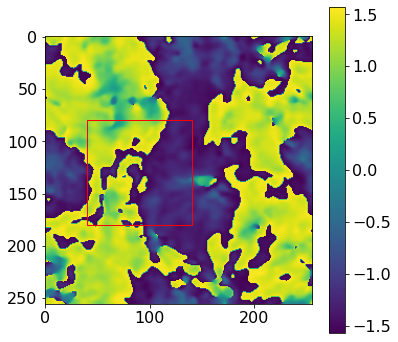

<ipython-input-3-18c81dd1a39a>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_r = np.array(delta_r)
<ipython-input-3-18c81dd1a39a>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_phi = np.array(delta_phi[:-1]) # Last value is added twice for some reason.


In [16]:
data = fits.open("L10_0.2.fits")[0].data

data = data[::2, ::2]
y_cen = 260 / 2
x_cen = 180 / 2
rad = 100 

dt = data_cut(x_cen, y_cen, rad, data, show=True)
dr_02, dphi_02 = cos_disp_calculations(dt, ds_scale=2)

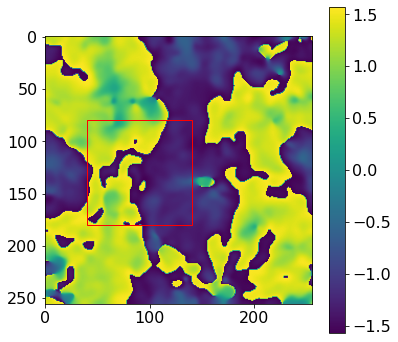

<ipython-input-3-18c81dd1a39a>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_r = np.array(delta_r)
<ipython-input-3-18c81dd1a39a>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_phi = np.array(delta_phi[:-1]) # Last value is added twice for some reason.


In [10]:
data = fits.open("L10_0.3.fits")[0].data

data = data[::2, ::2]
y_cen = 260 / 2
x_cen = 180 / 2
rad = 100 

dt = data_cut(x_cen, y_cen, rad, data, show=True)
dr_03, dphi_03 = cos_disp_calculations(dt, ds_scale=2)

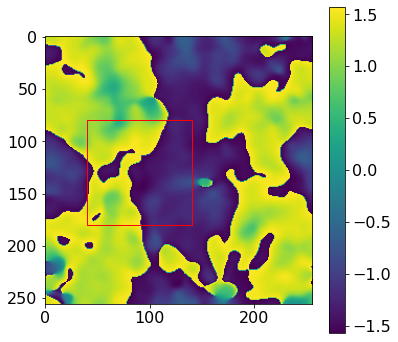

<ipython-input-3-18c81dd1a39a>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_r = np.array(delta_r)
<ipython-input-3-18c81dd1a39a>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_phi = np.array(delta_phi[:-1]) # Last value is added twice for some reason.


In [11]:
data = fits.open("L10_0.4.fits")[0].data

data = data[::2, ::2]
y_cen = 260 / 2
x_cen = 180 / 2
rad = 100 

dt = data_cut(x_cen, y_cen, rad, data, show=True)
dr_04, dphi_04 = cos_disp_calculations(dt, ds_scale=2)

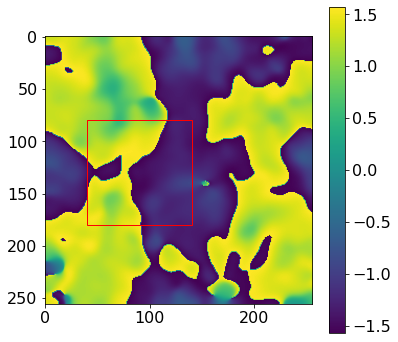

<ipython-input-3-18c81dd1a39a>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_r = np.array(delta_r)
<ipython-input-3-18c81dd1a39a>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_phi = np.array(delta_phi[:-1]) # Last value is added twice for some reason.


In [12]:
data = fits.open("L10_0.5.fits")[0].data

data = data[::2, ::2]
y_cen = 260 / 2
x_cen = 180 / 2
rad = 100 

dt = data_cut(x_cen, y_cen, rad, data, show=True)
dr_05, dphi_05 = cos_disp_calculations(dt, ds_scale=2)

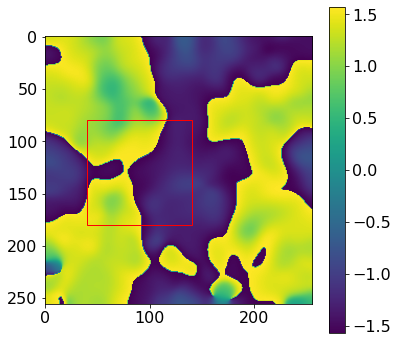

<ipython-input-3-18c81dd1a39a>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_r = np.array(delta_r)
<ipython-input-3-18c81dd1a39a>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  delta_phi = np.array(delta_phi[:-1]) # Last value is added twice for some reason.


In [13]:
data = fits.open("L10_0.65.fits")[0].data

data = data[::2, ::2]
y_cen = 260 / 2
x_cen = 180 / 2
rad = 100 

dt = data_cut(x_cen, y_cen, rad, data, show=True)
dr_065, dphi_065 = cos_disp_calculations(dt, ds_scale=2)

Y-intercept:  0.07429646275104818
Amplitude, sigma
Gaussian parameters are:  [0.06152999 0.1955741 ]
FWHM:  0.4595991313131897
Y-intercept:  0.05591491473335164
Amplitude, sigma
Gaussian parameters are:  [0.04829238 0.32139228]
FWHM:  0.7552718465323728


<ipython-input-3-18c81dd1a39a>:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 1)
<ipython-input-3-18c81dd1a39a>:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 2)
<ipython-input-3-18c81dd1a39a>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and r

Y-intercept:  0.04794141247970973
Amplitude, sigma
Gaussian parameters are:  [0.04344126 0.40857975]
FWHM:  0.9601624238023698


<ipython-input-3-18c81dd1a39a>:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 1)
<ipython-input-3-18c81dd1a39a>:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 2)
<ipython-input-3-18c81dd1a39a>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and r

Y-intercept:  0.04322478224135018
Amplitude, sigma
Gaussian parameters are:  [0.04020069 0.46530606]
FWHM:  1.0934692485919222


<ipython-input-3-18c81dd1a39a>:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 1)
<ipython-input-3-18c81dd1a39a>:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 2)
<ipython-input-3-18c81dd1a39a>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and r

Y-intercept:  0.039076480721296186
Amplitude, sigma
Gaussian parameters are:  [0.03697332 0.5108391 ]
FWHM:  1.2004718933802385


<ipython-input-3-18c81dd1a39a>:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 1)
<ipython-input-3-18c81dd1a39a>:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 2)
<ipython-input-3-18c81dd1a39a>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and r

Y-intercept:  0.033108089300273
Amplitude, sigma
Gaussian parameters are:  [0.03189901 0.56620552]
FWHM:  1.3305829765642943


<ipython-input-3-18c81dd1a39a>:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 1)
<ipython-input-3-18c81dd1a39a>:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 2)
<ipython-input-3-18c81dd1a39a>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and r

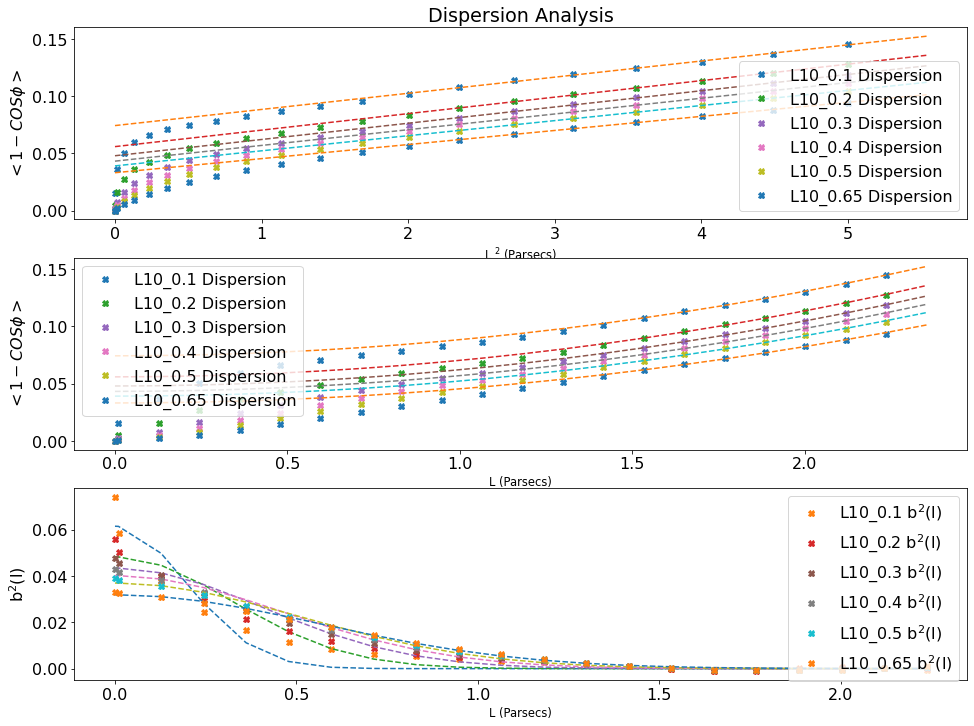

In [20]:
multi_fit(dr_01, dphi_01, 'L10_0.1', ds_scale=1, bin_edge=120, fit0=13, fitf=21, show=True)
multi_fit(dr_02, dphi_02, 'L10_0.2', ds_scale=2, bin_edge=120, fit0=13, fitf=21, show=True)
multi_fit(dr_03, dphi_03, 'L10_0.3', ds_scale=2, bin_edge=120, fit0=13, fitf=21, show=True)
multi_fit(dr_04, dphi_04, 'L10_0.4', ds_scale=2, bin_edge=120, fit0=13, fitf=21, show=True)
multi_fit(dr_05, dphi_05, 'L10_0.5', ds_scale=2, bin_edge=120, fit0=13, fitf=21, show=True)
multi_fit(dr_065, dphi_065, 'L10_0.65', ds_scale=2, bin_edge=120, fit0=13, fitf=21, show=True)